# STDP - network

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/STDP2.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/STDP2.ipynb)

In [1]:
#!pip install ANNarchy

A simple model showing the STDP learning rule on inputs converginf to a single neuron. Model adapted from Song, Miller and Abbott (2000) and Song and Abbott (2001)

Code adapted from the Brian example: http://brian.readthedocs.org/en/1.4.1/examples-plasticity_STDP1.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 5.0 (5.0.0) on darwin (posix).


Some parameters:

In [3]:
F = 15.0 # Poisson distribution at 15 Hz
N = 1000 # 1000 Poisson inputs
gmax = 0.01 # Maximum weight
duration = 100000.0 # Simulation for 100 seconds

Integrate-and-fire neuron:

In [4]:
IF = ann.Neuron(
    parameters = dict(
        tau_m = 10.0,
        tau_e = 5.0 ,
        vt = -54.0 ,
        vr = -60.0 ,
        El = -74.0 ,
        Ee = 0.0 ,
    ),
    equations = [
        ann.Variable('tau_m * dv/dt = El - v + g_exc * (Ee - vr)', init = -60.0),
        ann.Variable('tau_e * dg_exc/dt = - g_exc'),
    ],
    spike = "v > vt",
    reset = "v = vr",
)

An input population of Poisson neurons, and a single post-synaptic neuron.

In [5]:
# Network
net = ann.Network()

# Input population
Input = net.create(ann.PoissonPopulation(geometry=N, rates=F, name = 'Input'))

# Output neuron
Output = net.create(geometry=1, neuron=IF, name = 'Output')

# Projection learned using STDP
proj = net.connect( 
    pre = Input, 
    post = Output, 
    target = 'exc',
    synapse = ann.STDP(tau_plus=20.0, tau_minus=20.0, A_plus=0.01, A_minus=0.0105, w_max=0.01)
)
proj.connect_all_to_all(weights=ann.Uniform(0.0, gmax))


# Compile the network
net.compile()

Compiling network 1...  OK 


In [6]:
# Start recording
Mi = net.monitor(Input, 'spike') 
Mo = net.monitor(Output, 'spike')

# Start the simulation
net.simulate(duration, measure_time=True)

# Retrieve the recordings
input_spikes = Mi.get('spike')
output_spikes = Mo.get('spike')

Simulating 100.0 seconds of the network 1 took 0.8422238826751709 seconds. 


In [7]:
# Compute the mean firing rates during the simulation
print('Mean firing rate in the input population: ' + str(Mi.mean_fr(input_spikes)) )
print('Mean firing rate of the output neuron: ' + str(Mo.mean_fr(output_spikes)) )

# Compute the instantaneous firing rate of the output neuron
output_rate = Mo.smoothed_rate(output_spikes, 100.0)

# Receptive field after simulation
weights = proj.w[0]

Mean firing rate in the input population: 14.991800000000001
Mean firing rate of the output neuron: 26.110000000000003


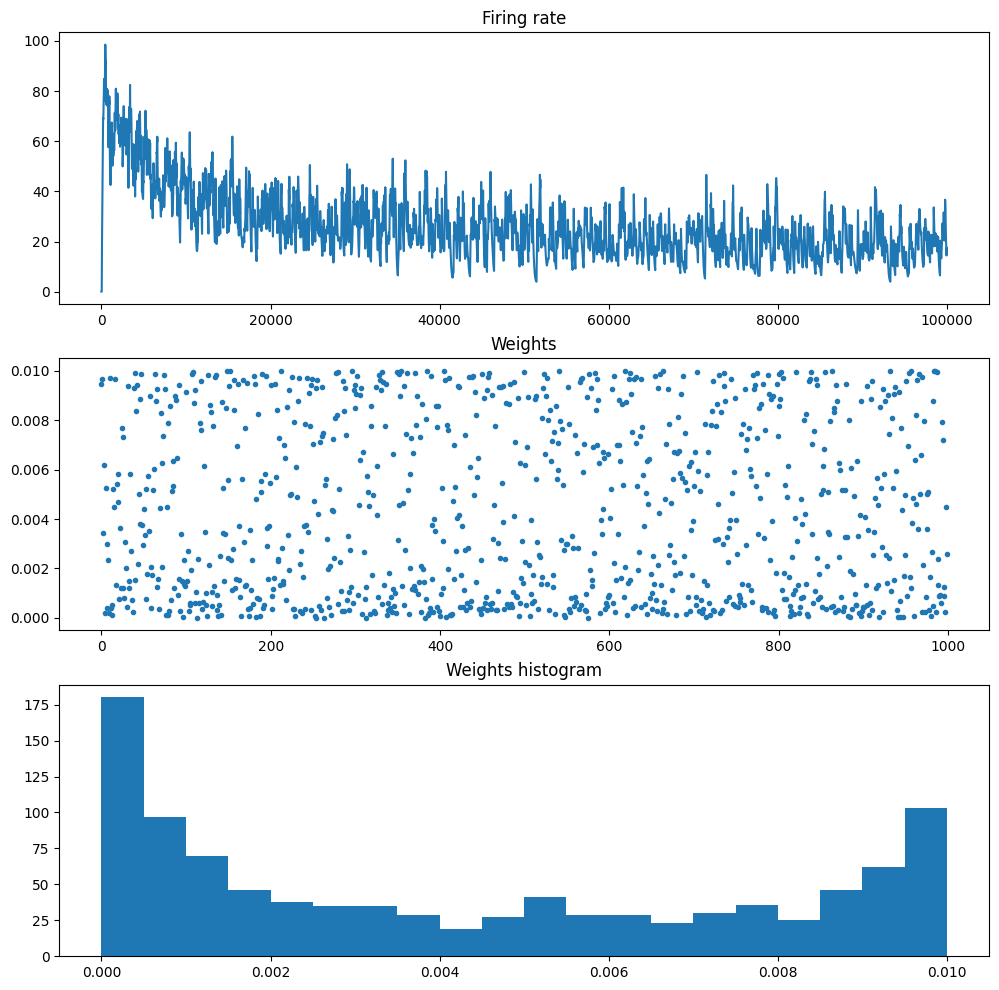

In [8]:
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.title('Firing rate')
plt.plot(output_rate[0, :])
plt.subplot(3,1,2)
plt.title('Weights')
plt.plot(weights, '.')
plt.subplot(3,1,3)
plt.title('Weights histogram')
plt.hist(weights, bins=20)
plt.show()